In [1]:
# Want to track the dow jones and use indicators
# from: https://medium.com/fintechexplained/automating-stock-investing-technical-analysis-with-python-81c669e360b2
# MACD
# Calculate the MACD line: 
"""
Calculate the 26-day exponentially weighted moving average of the price. This is the long term line.
Calculate the 12-day exponentially weighted moving average of the price. This is the short term line.
Calculate the difference between the 26-day EMA and 12-day EMA lines. This is the MACD line.
"""
# Calculate the Signal line from the MACD line:
"""
Calculate the 9 days exponentially weighted moving average of the MACD line. This is known as the signal line.
We can then calculate the difference between the MACD and the Signal line and then plot it as a histogram. 
The histogram can help us find when the cross-over is about to happen.
"""
# RSI
"""
The calculation is extremely simple.
Firstly, we have to determine the time period. Usually, a 14 day time period is chosen but it could depend on the investor’s own view of the market and the stock.
Secondly, we have to compute the relative strength which is known as RS. RS is the average gain over the average loss. To explain it further, RS is the average gain when the price was moving up over the average loss when the price change was negative.
Calculate RSI as 100 — (100/(1+RS))
The RSI value is between 0–100
"""
# Bollinger Bands
"""
Middle band: Calculate the moving average of the price, usually 20 days moving average.
Upper band: Calculate two standard deviations above the moving average.
Lower band: Calculate two standard deviations below the moving average.
"""

'\nMiddle band: Calculate the moving average of the price, usually 20 days moving average.\nUpper band: Calculate two standard deviations above the moving average.\nLower band: Calculate two standard deviations below the moving average.\n'

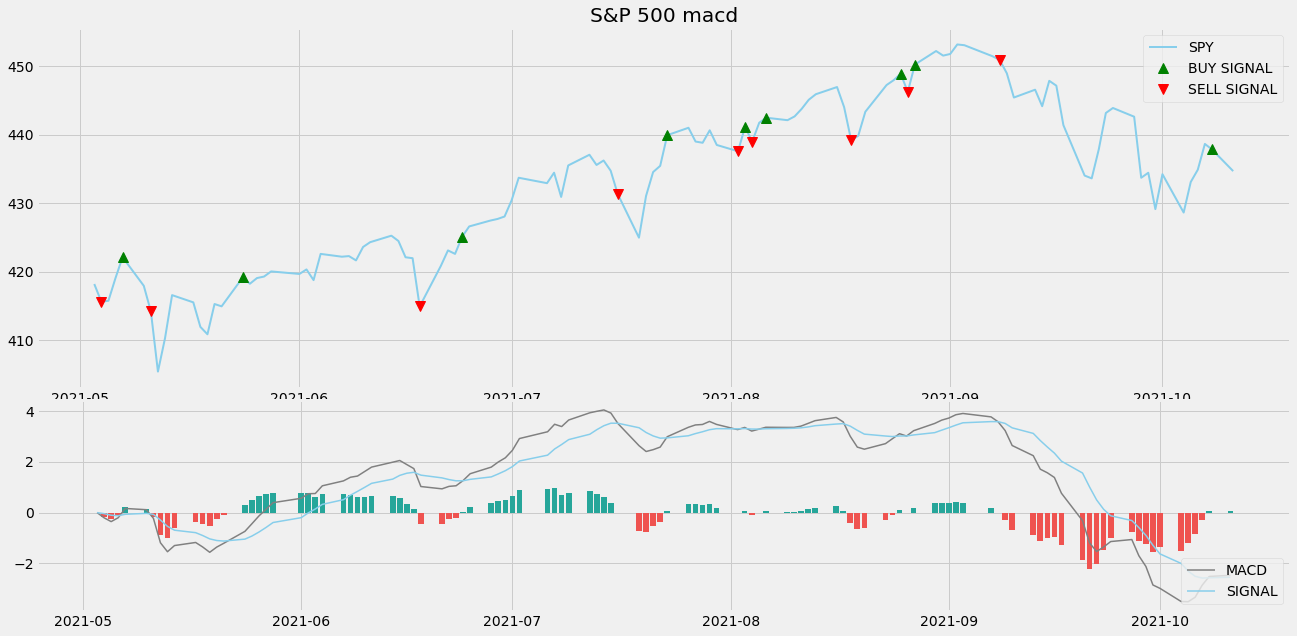

In [2]:
# MACD
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

def get_historical_data(symbol, start_date = None):
    api_key = '00f83bac51mshba5c44255841b11p11d607jsnf6d25aeeaebe'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&market=CNY&apikey={api_key}&outputsize=full'
    # 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market=CNY&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

googl = get_historical_data('SPY', '2021-05-01')
googl


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

googl_macd = get_macd(googl['close'], 26, 12, 9)
googl_macd.tail()

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(googl['close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])

def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(googl['close'], googl_macd)

ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(googl['close'], color = 'skyblue', linewidth = 2, label = 'SPY')
ax1.plot(googl.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(googl.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('S&P 500 macd')
ax2.plot(googl_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(googl_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(googl_macd)):
    if str(googl_macd['hist'][i])[0] == '-':
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

               open      high     low   close   adj close       volume
2021-03-16  397.070  397.8300  395.08  395.91  392.042719   73722506.0
2021-03-17  394.530  398.1200  393.30  397.26  393.379532   97959265.0
2021-03-18  394.475  396.7200  390.75  391.48  387.655992  115349101.0
2021-03-19  389.880  391.5690  387.15  389.48  386.940834  113624490.0
2021-03-22  390.030  394.0700  389.97  392.59  390.030559   73778646.0
...             ...       ...     ...     ...         ...          ...
2021-10-05  430.240  435.4900  429.39  433.10  433.100000   90682520.0
2021-10-06  429.270  435.1199  427.54  434.90  434.900000  113032245.0
2021-10-07  438.390  441.6800  438.20  438.66  438.660000   72437499.0
2021-10-08  439.480  439.8900  437.19  437.86  437.860000   74557404.0
2021-10-11  437.160  440.2600  434.62  434.69  434.690000   65233285.0

[146 rows x 6 columns]
              open      high     low   close   adj close       volume  \
2021-03-22  390.03  394.0700  389.97  392.59  390.0

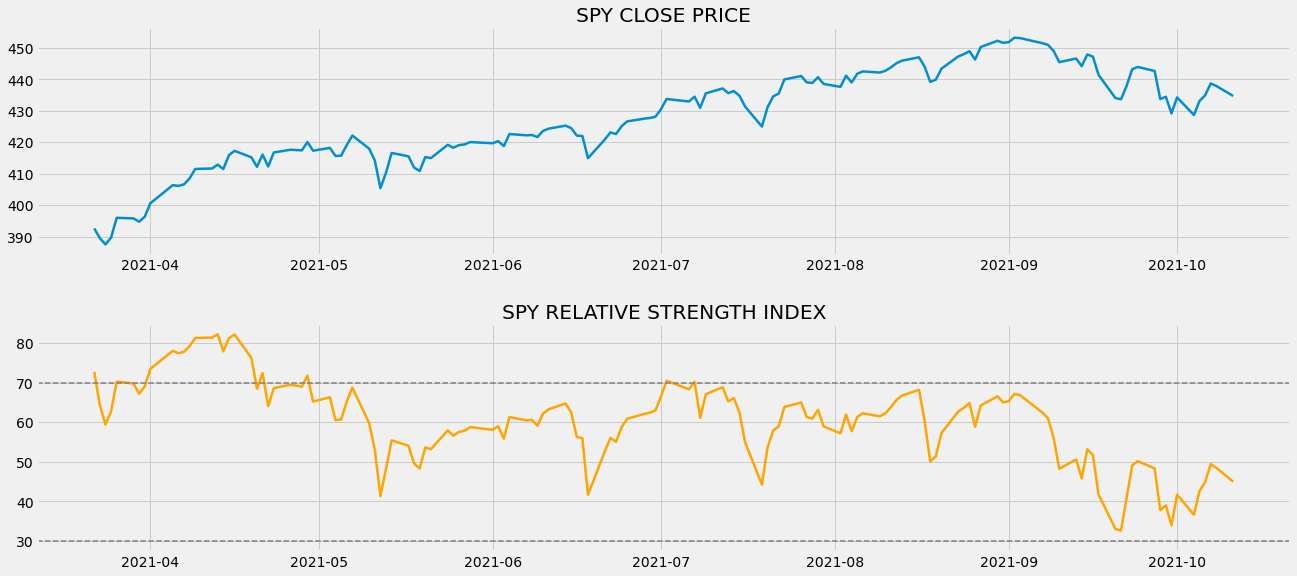

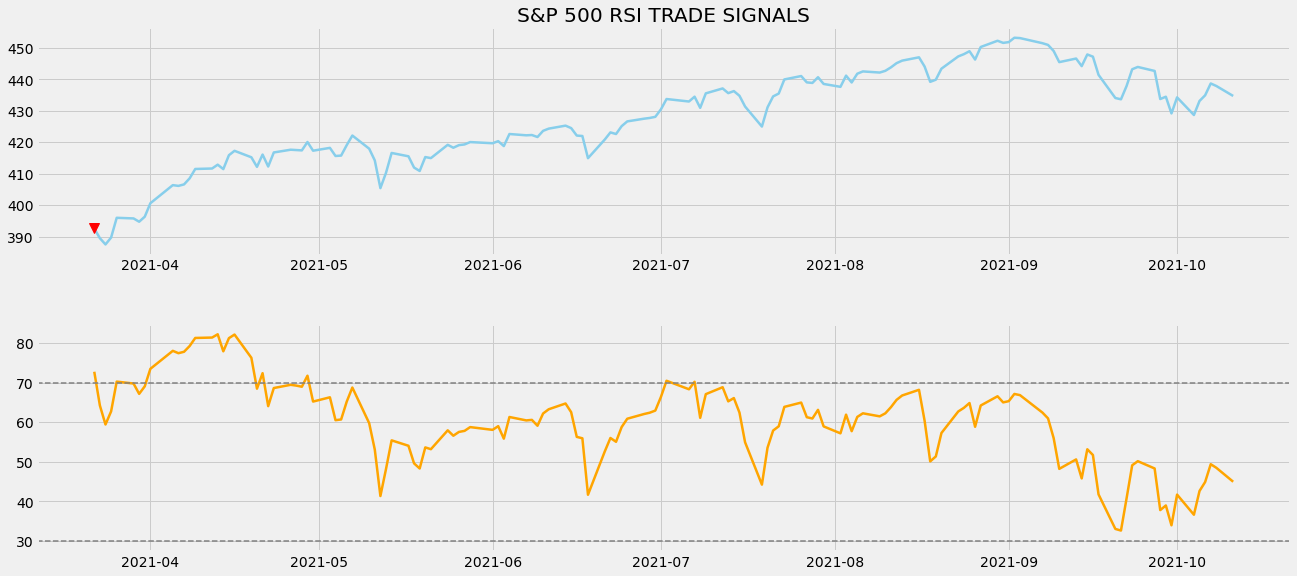

             close     rsi_14  rsi_signal  rsi_position
2021-03-22  392.59  72.727217          -1             0
2021-03-23  389.50  64.208906           0             0
2021-03-24  387.52  59.407288           0             0
2021-03-25  389.70  62.713425           0             0
2021-03-26  395.98  70.234415           0             0
Profit gained from the RSI strategy by investing $100k in GBTC : 0.0
Profit percentage of the RSI strategy : 0%


In [3]:
# RSI
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

def get_historical_data(symbol, start_date = None):
    api_key = '00f83bac51mshba5c44255841b11p11d607jsnf6d25aeeaebe'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

ibm = get_historical_data('SPY', '2021-03-16')
print(ibm)

def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

ibm['rsi_14'] = get_rsi(ibm['close'], 14)
ibm = ibm.dropna()
print(ibm)

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5)
ax1.set_title('SPY CLOSE PRICE')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('SPY RELATIVE STRENGTH INDEX')
plt.show()

def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(ibm['close'], ibm['rsi_14'])

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax1.plot(ibm.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(ibm.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('S&P 500 RSI TRADE SIGNALS')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(ibm['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = ibm['rsi_14']
close_price = ibm['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(ibm.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(ibm.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

print(strategy.head())

ibm_ret = pd.DataFrame(np.diff(ibm['close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(ibm_ret)):
    returns = ibm_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/ibm['close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in GBTC : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

In [4]:
import pandas as pd

from_symbol = 'ETH'
to_symbol = 'USD'
exchange = 'Bitstamp'
datetime_interval = 'day'

import requests
from datetime import datetime


def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)


def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals

    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)

    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data


def convert_to_dataframe(data):
    df = pd.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df


def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df


data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

Filtering 567 empty datapoints
Saving data to ETH_USD_Bitstamp_day_2021-10-12.csv


In [5]:
import pandas as pd

def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

df = read_dataset(filename)

Reading data from ETH_USD_Bitstamp_day_2021-10-12.csv
(1434, 6)


In [6]:
from stockstats import StockDataFrame
df = StockDataFrame.retype(df)
df['macd'] = df.get('macd') # calculate MACD

In [7]:
from math import pi

from bokeh.plotting import figure, show, output_notebook, output_file
output_notebook()

datetime_from = '2021-01-01 00:00'
datetime_to = '2021-12-10 00:00'


def get_candlestick_width(datetime_interval):
    if datetime_interval == 'minute':
        return 30 * 60 * 1000  # half minute in ms
    elif datetime_interval == 'hour':
        return 0.5 * 60 * 60 * 1000  # half hour in ms
    elif datetime_interval == 'day':
        return 12 * 60 * 60 * 1000  # half day in ms


df_limit = df[datetime_from: datetime_to].copy()
inc = df_limit.close > df_limit.open
dec = df_limit.open > df_limit.close

title = '%s datapoints from %s to %s for %s and %s from %s with MACD strategy' % (
    datetime_interval, datetime_from, datetime_to, from_symbol, to_symbol, exchange)
p = figure(x_axis_type="datetime",  plot_width=1000, title=title)

p.line(df_limit.index, df_limit.close, color='black')

# plot macd strategy
p.line(df_limit.index, 0, color='black')
p.line(df_limit.index, df_limit.macd, color='blue')
p.line(df_limit.index, df_limit.macds, color='orange')
p.vbar(x=df_limit.index, bottom=[
       0 for _ in df_limit.index], top=df_limit.macdh, width=4, color="purple")

# plot candlesticks
candlestick_width = get_candlestick_width(datetime_interval)
p.segment(df_limit.index, df_limit.high,
          df_limit.index, df_limit.low, color="black")
p.vbar(df_limit.index[inc], candlestick_width, df_limit.open[inc],
       df_limit.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df_limit.index[dec], candlestick_width, df_limit.open[dec],
       df_limit.close[dec], fill_color="#F2583E", line_color="black")

output_file("visualizing_trading_strategy.html", title="visualizing trading strategy")
show(p)

Loading BokehJS ...

Start date: 2020-03-18
End date: 2021-10-12


,Backtest
,
Annual return,91.9%
Cumulative return,177.06%
Annual volatility,27.63 %
Winning day ratio,58.38%
Sharpe ratio,2.5
Calmar ratio,7.1
Information ratio,0.01
Stability,0.93
Max Drawdown,-12.93 %


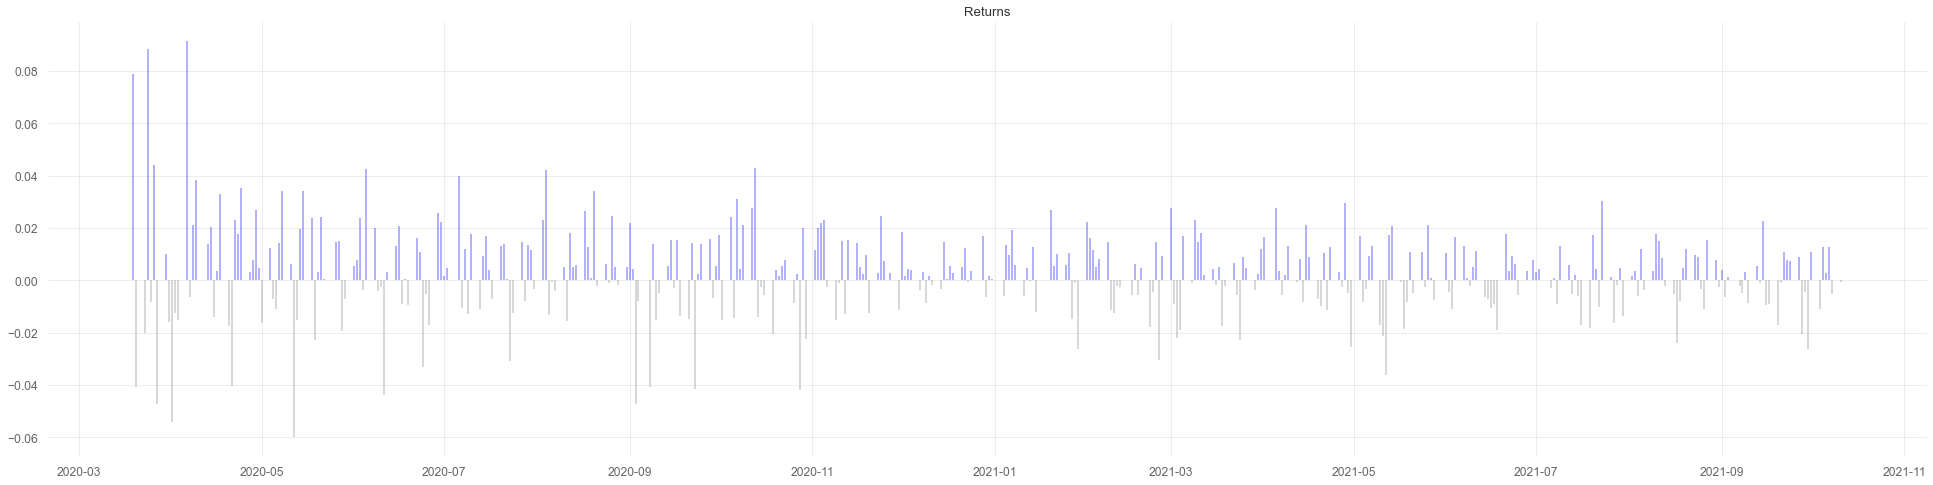

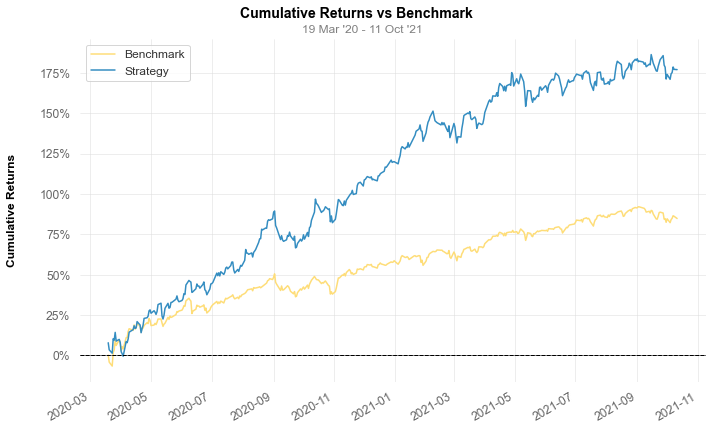

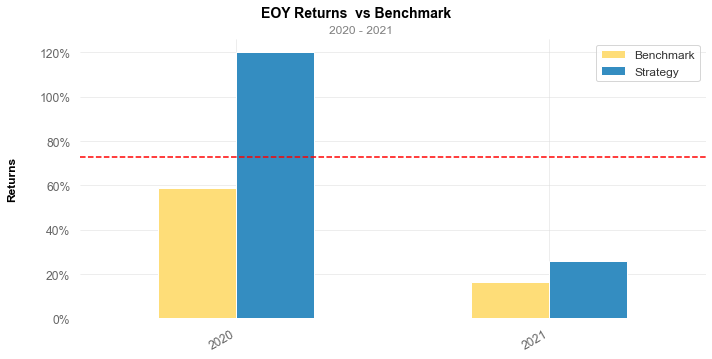

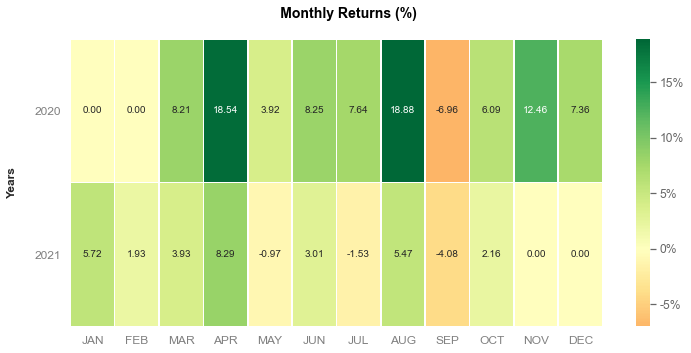

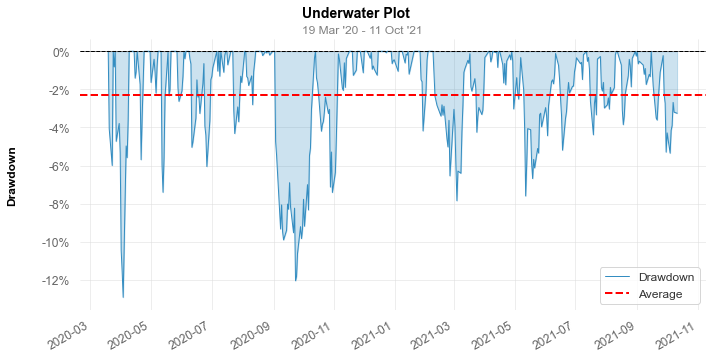

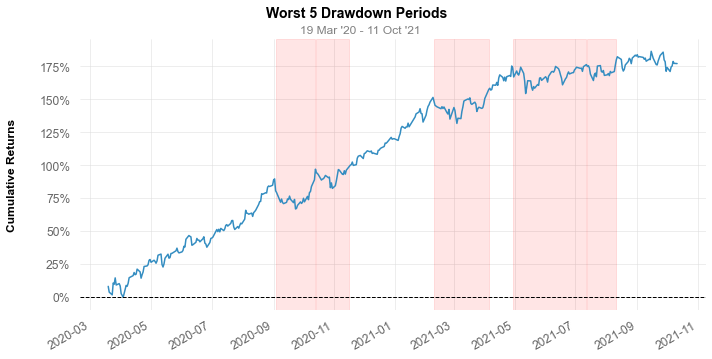

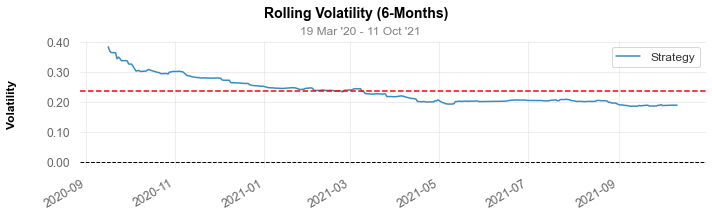

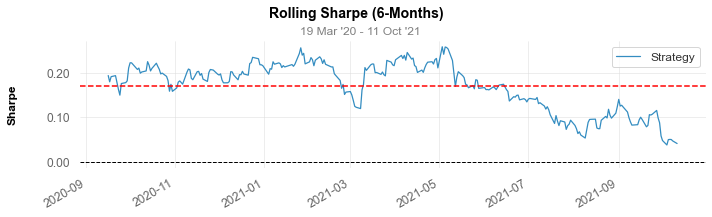

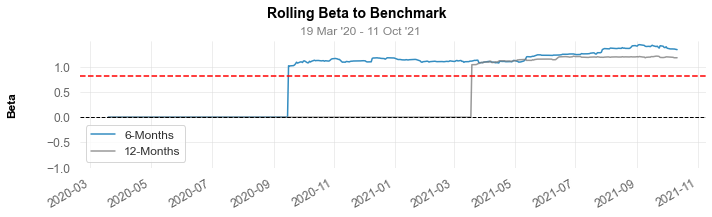

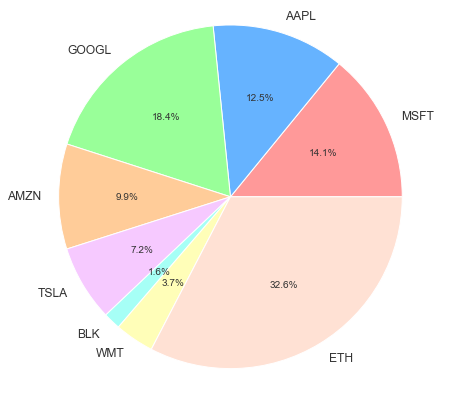

(None, None, None, None, None, None, None, None, None)

In [8]:
from empyrial import empyrial, Engine

portfolio = Engine(    
         start_date= "2020-03-18", 
         portfolio= ["MSFT", "AAPL", "GOOGL", "AMZN","TSLA", "BLK", "WMT", "ETH"], 
         weights = [0.141, 0.1252, 0.1843, 0.0989, 0.0716, 0.0162, 0.0369, 0.3263], 
         benchmark = ["SPY"], #SPY is set by default
         rebalance = "1y"
)

empyrial(portfolio)
get_report(por)


In [9]:
from empyrial import empyrial, Engine
d


NameError: name 'd' is not defined

In [ ]:
from empyrial import get_report, Engine
portfolio = Engine(
      start_date = "2018-01-01",
      portfolio = ["BLK", "BAC", "AAPL", "TM", "JPM","JD", "INTU", "NVDA", "DIS", "TSLA"],
      optimizer = "EF",
      rebalance = "1y", #rebalance every year
      risk_manager = {"Stop Loss" : -0.2}
)
get_report(portfolio)
